**API URL for METRO and SOCRATA Work**

In [1]:
# import libraries
import urllib.request, json 
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

*API URL*

In [2]:
# api url for metro stops along route 4 which is similar to 2 which we did in class
# both routes run near Elysian Park
metro_url = 'https://api.metro.net/agencies/lametro/routes/4/stops/'

with urllib.request.urlopen(metro_url) as url:
    data = json.loads(url.read().decode())
    
df = pd.json_normalize(data,'items')
df

display_name     id  latitude  longitude
0          Santa Monica / 20th  14357  34.02859 -118.48036
1    Santa Monica / La Cienega  16240  34.08988 -118.37604
2       Santa Monica / Western  14436  34.09066 -118.30891
3      Santa Monica / Sawtelle  06046  34.04635 -118.44853
4              Sunset / Portia  06393  34.07537 -118.25446
..                         ...    ...       ...        ...
203      Sunset / Micheltorena  08025  34.08759 -118.27602
204      Santa Monica / Virgil  14414  34.09100 -118.28650
205     Santa Monica / Bronson  00871  34.09063 -118.31773
206                Hill / 11th  05130  34.04001 -118.26010
207     Santa Monica / Formosa  05995  34.09061 -118.34640

[208 rows x 4 columns]

In [3]:
# convert df to gdf
gdf = gpd.GeoDataFrame(df, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(df.longitude, df.latitude))

gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
# project data
gdf_web_mercator = gdf.to_crs(epsg=3857)

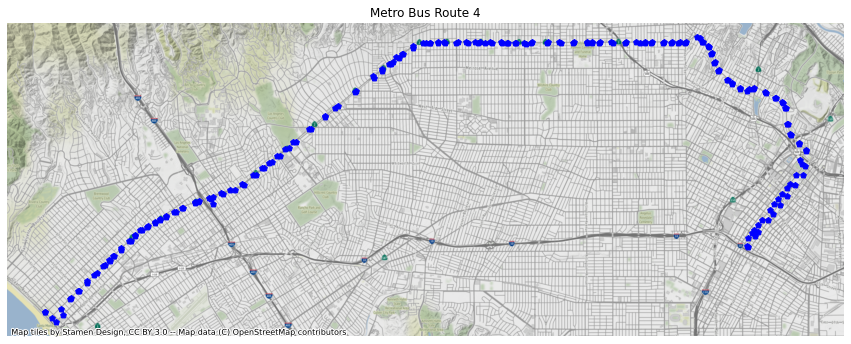

In [5]:
# map

fig, ax = plt.subplots(figsize=(15,10))
gdf_web_mercator.plot(ax=ax, marker='p', color='blue')
ax.axis('off')
ax.set_title('Metro Bus Route 4')
ctx.add_basemap(ax)

*Socrata Chart Creation*

In [6]:
# import new libraries for interactive map
import pandas as pd
import plotly.express as px
from sodapy import Socrata

Selected LA City Data for Parks

In [7]:
# socrata
client = Socrata("data.lacity.org", None)
results = client.get("rwq7-yhp5", limit=2000)

# convert to pandas df
df = pd.DataFrame.from_records(results)
df.sample(3)

the_geom objectid  \
240  {'type': 'MultiPolygon', 'coordinates': [[[[-1...      231   
185  {'type': 'MultiPolygon', 'coordinates': [[[[-1...      200   
222  {'type': 'MultiPolygon', 'coordinates': [[[[-1...      208   

                      name_alpha     area_acres park_id cd_real name_publi  \
240  SEPULVEDA RECREATION CENTER  10.5872268364     192      06        NaN   
185            PORTER RANCH PARK    40.96206577     772      12        NaN   
222                  RESEDA PARK  29.6785210034     517      03        NaN   

                                    address region  \
240  8825 N Kester Ave, Panorama City 91402      V   
185                11000 N Tampa Ave, 91326      V   
222             18411 W Victory Blvd, 91335      V   

                            name issubpark park_class     shape_leng  \
240  Sepulveda Recreation Center         N          C   3376.4451796   
185            Porter Ranch Park         N          R   18320.871137   
222                  Reseda Park         N          C  7672.12369484   

        shape_area  
240  461177.756276  
185  1784300.44772  
222  1292791.20373

In [8]:
df.loc[df['name_alpha']=='GRIFFITH PARK']

the_geom objectid  \
398  {'type': 'MultiPolygon', 'coordinates': [[[[-1...      369   

        name_alpha     area_acres park_id cd_real name_publi  \
398  GRIFFITH PARK  4282.66874049     161      04        NaN   

                                 address region           name issubpark  \
398  4730 N Crystal Springs Dr, LA 90027      G  Griffith Park         N   

    park_class     shape_leng     shape_area  
398          R  271026.824096  186526113.705

Narrowed down data to Recreation Parks

In [9]:
RR = df.loc[df['park_class'] == 'R']
RR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 8 to 560
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   the_geom    119 non-null    object
 1   objectid    119 non-null    object
 2   name_alpha  119 non-null    object
 3   area_acres  119 non-null    object
 4   park_id     119 non-null    object
 5   cd_real     119 non-null    object
 6   name_publi  54 non-null     object
 7   address     119 non-null    object
 8   region      119 non-null    object
 9   name        119 non-null    object
 10  issubpark   119 non-null    object
 11  park_class  119 non-null    object
 12  shape_leng  119 non-null    object
 13  shape_area  119 non-null    object
dtypes: object(14)
memory usage: 13.9+ KB


In [10]:
px.bar(RR,
       x ='issubpark',
       title ='Are the parks inside another park?',
       labels = {'name_alpha': 'Park Name', 'park_id': 'Park ID#', 'area_acres': 'Area of Park'}
      )

Analyzing Park Data in Charts

In [11]:
# bad chart example with excessive data
px.bar(RR,
       x = 'name',
       y = 'area_acres',
      title = 'Areas of Parks')

# ideally I would like to improve this chart by RR_big = df.loc[RR['area_acres'] > 500]
# this would look for parks larger than 500 acres, however, the data types are objects so I am unable to do so

In [12]:
RR['acres'] = RR['area_acres'].astype(float)
RR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 8 to 560
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   the_geom    119 non-null    object 
 1   objectid    119 non-null    object 
 2   name_alpha  119 non-null    object 
 3   area_acres  119 non-null    object 
 4   park_id     119 non-null    object 
 5   cd_real     119 non-null    object 
 6   name_publi  54 non-null     object 
 7   address     119 non-null    object 
 8   region      119 non-null    object 
 9   name        119 non-null    object 
 10  issubpark   119 non-null    object 
 11  park_class  119 non-null    object 
 12  shape_leng  119 non-null    object 
 13  shape_area  119 non-null    object 
 14  acres       119 non-null    float64
dtypes: float64(1), object(14)
memory usage: 14.9+ KB


<ipython-input-12-76450f71a88a>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
RR.sample()

the_geom objectid  \
445  {'type': 'MultiPolygon', 'coordinates': [[[[-1...      424   

          name_alpha     area_acres park_id cd_real  \
445  HERITAGE SQUARE  4.16434554101     716      01   

                                            name_publi  \
445  Heritage Square Museum, Heritage Square Histor...   

                       address region             name issubpark park_class  \
445  3800 N Homer St, LA 90031      M  Heritage Square         N          R   

        shape_leng     shape_area     acres  
445  3533.22439495  181398.166171  4.164346

In [15]:
RR_Big = RR.loc[RR['acres'] > 500]
px.bar(RR_Big,
       x = 'name',
       y = 'area_acres',
      title = 'Areas of Parks')
# converting types did not work, moving on...